## Grid simulations mini-project
#### Author: Hannah Sheahan
#### Date: 11/07/2019

#### There are two questions to answer here in this mini-project:
##### 1. Can you get 6-fold modulations in aggregate signal by making randomly directed traversals across a square environment if the underlying neural representation of that space is 6-fold symmetric, just by stacking layers of representations of different scales (according to the known scale difference between them) and with some relative phases between each grid layer.
##### ***HRS the next step in this is to vary the parameters as a grid search (but not phase), fitting a 6-fold symmetric sinusoid to the resulting aggregate pattern each time to see what parameter conditions result in the 'most-hex' aggregate grid. 


##### 2. How might a 2D/4-fold symmetric structure emerge from a 6-fold grid structure? If 6-fold grid structure does exist, how do people say that they factorised representation into 2 axes? The issue with grid cell patterns (6 fold) is that they dont factorise into 2 dimensions. So how does that transformation/computation take place? This is relevant theory both for the Constantinescu paper and the odor paper.

##### 3. What if noise is not symmetric in 2D? i.e. y- and x- gaussian noise is assymetric. There is no obvious reason which way around this should go in 2D cases, but I wonder about what this might do to the inferred lattice just based off of the traversal fMRI literature. Could this give rise to a 6-fold looking lattice when really there is a 4-fold one?

In [1]:
import gridHelperFunctions as gf
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import optimize
from scipy import signal
import sklearn
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
import math
import sys
import time
import random
%matplotlib inline

## 1.  Create a basic initial layer grid simulator
#### Use a coding scheme made up from gaussians with independent noise and spacing variables, i.e. with variables for:
###### - spacing between them
###### - noise in each gaussian
###### - angle of code orientation
###### - phase anchor

##### Note: defining sinusoids over odd and even rows will not work, as you will end up stretching the grid in the y-axis

Example grids: hex, square, rectangular


/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


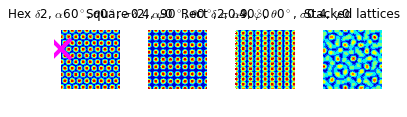

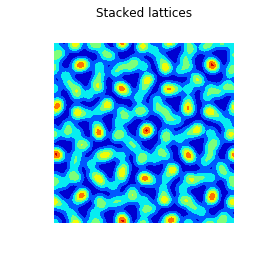

In [2]:
# Free parameters
gridxspacing = 2
noise = 0.4
angle = 0                      # anti-clockwise rotation
phase = 0                       # distance from centre of square in x-dim
resolution = 100                 # number of points on x-dim
gridrange = [-8, 8]
plotrange = [-10, 10]
coordMethod = 1
#-----------------------
print("Example grids: hex, square, rectangular")
# Create a hex grid
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#f, (ax1, ax2, ax3) = plt.subplots(1, 3)
x,y,z = gf.createHexGrid(gridxspacing, noise, angle, phase, resolution, gridrange, plotrange, coordMethod) 
gf.plotGrid(ax1, x, y, z, plotrange, "Hex", False, gridxspacing, 60, phase, angle, noise)  # beware that if the gridxspacing maxes out this descriptor will be incorrect for the real grid.
ax1.set_aspect('equal', adjustable='box')

# choose a random max point on the grid (empirical max, not based on known centres)
xloc, yloc = gf.findMaxPointCentre(z)
ax1.plot(x[xloc][yloc], y[xloc][yloc], marker='x',color='magenta', markersize=20, markeredgewidth=4)

# Create a square lattice for comparison
xs,ys,zs = gf.createSquareGrid(gridxspacing, noise, angle, phase, resolution, gridrange, plotrange)
gf.plotGrid(ax2, xs, ys, zs, plotrange, "Square", False, gridxspacing, 90, phase, angle, noise) 
ax2.set_aspect('equal', adjustable='box')

# Create a rectangular lattice for comparison
gridyspacing = gridxspacing*0.7
xr,yr,zr = gf.createRectGrid(gridxspacing, gridyspacing, noise, angle, phase, resolution, gridrange, plotrange)
gf.plotGrid(ax3, xr, yr, zr, plotrange, "Rect", False, gridxspacing, 90, phase, angle, noise) 
ax3.set_aspect('equal', adjustable='box')

# Create a lattice with a random axis A and axis B spacing and angle alpha
alpha = random.uniform(0,90)
xran,yran,zran = gf.createGrid(random.uniform(1,10), random.uniform(1,10), random.uniform(0,90), random.uniform(0,7), alpha,  phase, resolution, gridrange, plotrange)
gf.plotGrid(ax4, xran, yran, zran, plotrange, "Rect", False, gridxspacing,  alpha, phase, angle, noise) 
ax4.set_aspect('equal', adjustable='box')
ax4.set_title("Random parameters")

#-------------------------
# This is how you stack grids on top of each other
#_,_,z2 = gf.createHexGrid(gridxspacing*2, noise*2, angle, phase, resolution, gridrange, plotrange, coordMethod)
#_,_,z3 = gf.createHexGrid(gridxspacing*3, noise*5, 0, phase, resolution, gridrange, plotrange, coordMethod)


# Adjusting just the grid spacing produces something that looks 8-fold if using a 4-fold basis
xs,ys,z2 = gf.createSquareGrid(gridxspacing*1.4, noise, angle, phase, resolution, gridrange, plotrange)
xs,ys,z3 = gf.createSquareGrid(gridxspacing*1.4*1.4, noise, angle, phase, resolution, gridrange, plotrange)
xs,ys,z4 = gf.createSquareGrid(gridxspacing*1.4*1.4*1.4, noise, angle, phase, resolution, gridrange, plotrange)
xs,ys,z5 = gf.createSquareGrid(gridxspacing*1.4*1.4*1.4*1.4, noise, angle, phase, resolution, gridrange, plotrange)


# I guess we want to run a model on the resulting grid that determines what the fitting error is when you fit 6-fold to the net data
# Just by varying the angle and the phase and keeping the other parameters the same

# This will also give you ~5-fold
#xs,ys,z2 = gf.createSquareGrid(gridxspacing, noise, angle+15, phase, resolution, gridrange, plotrange)
#xs,ys,z3 = gf.createSquareGrid(gridxspacing, noise, angle+30, phase+gridxspacing/2, resolution, gridrange, plotrange)
#xs,ys,z4 = gf.createSquareGrid(gridxspacing, noise, angle+45, phase, resolution, gridrange, plotrange)
#xs,ys,z5 = gf.createSquareGrid(gridxspacing, noise, angle+60, phase+gridxspacing/2, resolution, gridrange, plotrange)
#xs,ys,z6 = gf.createSquareGrid(gridxspacing, noise, angle+75, phase, resolution, gridrange, plotrange)
#z = zs  + z3 + z5

# Assume the same grid spacing with a voxel - you can get what looks like 5 fold symmetry this way
xs,ys,z2 = gf.createSquareGrid(gridxspacing, noise, angle+15, phase, resolution, gridrange, plotrange)
xs,ys,z3 = gf.createSquareGrid(gridxspacing, noise, angle+30, phase+.5, resolution, gridrange, plotrange)
xs,ys,z4 = gf.createSquareGrid(gridxspacing, noise, angle+45, phase, resolution, gridrange, plotrange)
xs,ys,z5 = gf.createSquareGrid(gridxspacing, noise, angle+60, phase+.5, resolution, gridrange, plotrange)
xs,ys,z6 = gf.createSquareGrid(gridxspacing, noise, angle+75, phase+.5, resolution, gridrange, plotrange)
#z = zs  + z3 + z5

# under a 4-fold basis, stack layers, fixing one parameter and allow others to vary, see if we can get 6-fold, but Im not sure.
# chris seems to think it will just be some boring thing about BOLD neurophysiology
# its also worth considering in the Doeller visual result where they sample start and end positions on the unit circle.

#z = zs + z2 + z3 + z4 + z5 +z6
z = zs  + z3 + z5

gf.plotGrid(plt.gca(), x, y, z, plotrange, "Stacked lattices", False)

plt.figure()
gf.plotGrid(plt.gca(), x, y, z, plotrange, "Stacked lattices", False)


## 2. Write a function that evaluates the X-foldness of a given grid
##### So that we can see a plot of the evidence for a given grid being 6-fold v 5-fold v 4-fold etc

#### Symmetry Notes:
###### - Formally, each axis of symmetry requires that f(t) = f(-t), for values t along the axis T.
###### - If you have a perfect lattice the algorithm for n-fold symmetry is: 1) choose a random point, 2) then expand a radius from that point outwards until it finds the centre of the next closest point (by evaluating when heat starts going in negative gradient after being +ve gradient),3) then finds the line connecting those two, 4) then find the next most closest point that doesnt fall along the same axis. This defines your two grid axes. The distance between them and the angle between them define the form of the lattice. 5) ... Or just take the first line of radius R and rotate it 360 degrees then plot the generated heatmap. BUT! choosing your second point causes issues when you have a multi-scale or low resolution/noisy grid, since your second point as evaluated by the gradient might be a small bubble when the overwhelming pattern is big strong bubbles that are far apart.

#### Lattice-fitting Notes: 
###### - Having written a function to fit lattice parameters to generated data, it turns out lattice fitting is really hard numerical optimisation problem! Even fitting to a single parameter (grid spacing for 1 axis) produces a crazy bumpy fitting surface for even just one parameter! Some other parameters are easier like orientation or phase.

###### - Increasing the scale of z helps a bit because numerical optimisation performs poorly on v small or v large numbers and ours were pretty small
###### -Since the fitting surface is mega bumpy, instead define specific n-fold models with all params fixed just different specified n-fold, and see which one of these produces the best fit (argmin SSE).

#### N-Fold Evaluation Notes:
###### - the Dordek et al 2016 grid theory paper used the method for n-fold evaluation given in Sargonlini et al 2006 Science paper. Their method is:  1) find max peak of grid lattice - you will consider the parts around it. 2) define a circle of radius R that reaches and contains the first 6 ‘peaks’ as defined by X pixels above threshold next to each other. 3) Rotate the map enclosed by this circle through theta angles (at 6deg increments) and plot the covariance of the original map with each of the maps you get after rotation. 4) 


In [26]:
# Experiment with fitting different lattice parameters in isolation to data, to see how good lattice-classification is numerically
fitModel = False
if fitModel:
    maxiter = 2
    fitwhichparams = [0,0,0,0,0,1]
    initparams = [3, 3, 60, 0.4, 15, 3]
    fitted_params, fitted_SSE = gf.fitLattice(maxiter, z, fitwhichparams, initparams)

    #--------------------
    # See what the best fitting parameters were
    opt_iter = np.nanargmin(fitted_SSE)
    opt_params = fitted_params[opt_iter][:]
    str_params = ''.join("{:.2f}  ".format(e) for e in opt_params)
    print("Best fitting parameters: "+ str_params)
    
    # View how smooth the fitting surface was for the parameter
    ax = gf.visualizeParameterFit(5, fitted_params, fitted_SSE)
    
    # Plot the grids generated from the model next to data
    ax = gf.visualCompareGridModels(x, y, z, [opt_params], gridrange, plotrange)
        

In [27]:
# Simply the fitting by comparing a set of specific n-fold symmetry models (given A/B spacings, gaussian noise)
fitModel = False
if fitModel:
    maxiter = 3
    folds = [4, 6, 7]   # the candidate n-fold symmetry models we will compare
    otherparams = [3, 3, 0, 0.4, 0, 0]
    nfoldParams, nfoldSSE = gf.fitNFoldModels(maxiter, folds, z, otherparams, False)

    # Plot the grids generated from the model next to data
    ax = gf.visualCompareGridModels(x, y, z, nfoldParams, gridrange, plotrange)
    ax[0].set_title("Actual data")
    for i in range(len(folds)):
        ax[i+1].set_title("Fitted model: {:}-fold".format(folds[i]))


## 3. Have an agent make random traversals across a given square grid
##### of approx uniformly distributed distances and angles,  (i.e. sample the trajectories uniform randomly from a distance v angle space).

##### - plot the aggregate 'highs' traversed across the grid as a function of angle of movement

##### Note: uniform random start and end positions on a square give uniform sampling distribution of traj orientation, but shifted ~gaussian distribution of trajectory length (which will mean uneven sampling of distance, but importantly will give non-uniform sampling distance x angle covariance). We need to have uniform p(dist|angle) in order to do this fairly because otherwise aggregate activity will always be greater in angles corresponding to the diagonals. 

##### - So that means sampling these trajectories over a circle is the fair way to do it to get uniform p(dist|angle). Do this second. ... actually maybe its ok so long as we normalise the activity on a given trajectory over the number of cells hit?

/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


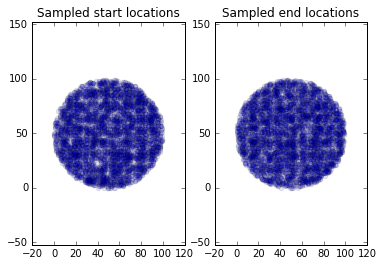

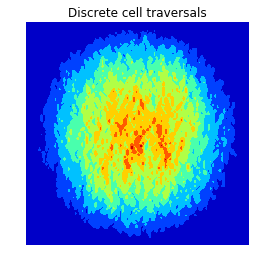

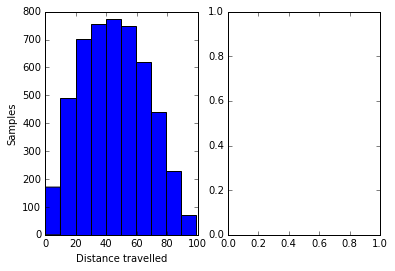

In [28]:
# Sample trajectories over a square...
# remember that you will need to normalize the aggregate activity over the number of x,y cells actually hit on a trajectory, because this will always be more closer to the cardinal axes than to 45 deg
# Note: uniform random start and end point sampling on a square produces non-uniform p(dist|angle) and this is important
numSamples = 5000

#distances, angles, netActivity, numCells = gf.sampleTrajectoriesSquare(numSamples, resolution, z, x, y)

# Now also try sampling uniformly across a circular space (this is equivalent to normalising value in 2D space, or making p(dist|angle) uniform)
distances, angles, netActivity, numCells = gf.sampleTrajectoriesCircle(numSamples, resolution, z, x, y)


plt.figure()
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(distances)
ax1.set_xlabel('Distance travelled')
ax1.set_ylabel('Samples')

#ax2.hist(angles)
#ax2.set_xlabel('Trajectory angle (CCW from +ve x-axis)')
#ax2.set_ylabel('Samples')

#------------------------------------
# ***HRS Q: why is the range of angle vectors only 0-180? shouldnt it be 360 by default? 
# if not, are we imposing/assuming horizontal axis symmetry by accident somehow?

# ***HRS the sampling of the space looks to be x,y axis aligned? like in clusters? wtf, this is probably whats imposing some sort of 4-fold symmetry
# I dont understand how that is coming about though. Discretisation to integer indices should be clustering at units of 1 pixel only.


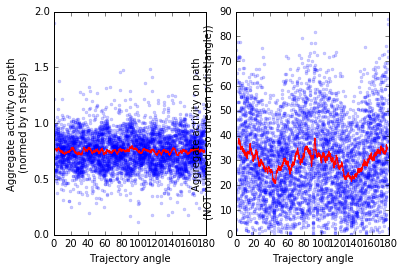

In [29]:
# Next to do: calculate the normalized aggregate activity across each path by dividing the total activity by number of cells activated on that path
# then plot norm agg activity vs angle of movement across grid

fig, ax = plt.subplots(1,2)
win = 100

# Norming activity by number of cells traversed (accounts for some angles across a square having further distances than others), ie nonflat p(dist|angle)
normPathActivity = np.divide(netActivity, numCells)

ax[0].plot(angles, normPathActivity, '.', alpha=0.2)
ax[0].set_xlabel('Trajectory angle')
ax[0].set_ylabel('Aggregate activity on path\n (normed by n steps)')

ind = np.argsort(angles, axis=0)
sortedAngles = angles[ind]
sortedNormPathActivity = normPathActivity[ind]

smoothNormPathActivity = np.convolve(np.reshape(sortedNormPathActivity, len(sortedNormPathActivity)), np.ones((win,))/win, mode='valid')
smoothSortedAngles = np.convolve(np.reshape(sortedAngles, len(sortedAngles)), np.ones((win,))/win, mode='valid')
ax[0].plot(smoothSortedAngles, smoothNormPathActivity, 'r')

#------
# Now repeat but without norming over cells traversed

ax[1].plot(angles, netActivity, '.', alpha=0.2)
ax[1].set_xlabel('Trajectory angle')
ax[1].set_ylabel('Aggregate activity on path\n (NOT normed, so uneven p(dist|angle))')

ind = np.argsort(angles, axis=0)
sortedAngles = angles[ind]
sortedPathActivity = netActivity[ind]

smoothPathActivity = np.convolve(np.reshape(sortedPathActivity, len(sortedPathActivity)), np.ones((win,))/win, mode='valid')
smoothSortedAngles = np.convolve(np.reshape(sortedAngles, len(sortedAngles)), np.ones((win,))/win, mode='valid')
ax[1].plot(smoothSortedAngles, smoothPathActivity, 'r')



[--------------------] 100% 
Optimisation complete (500 iterations, 19 s)
Fitting to normed data (uniform aross distance over square)...
Best fitting parameters: 0.009  18.383  53.367  0.750  
Best fitting periodicity: 18.383 degrees
Parameters yielded nan or inf sin output: 0.009 18.383 53.367 0.750
[False False False ... False  True  True]
[--------------------] 100% 
Optimisation complete (500 iterations, 14 s)
Fitting to NOT normed data (uniform aross start and end positions on square) ...
Best fitting parameters: 4.550  87.532  78.664  29.786  
Best fitting periodicity: 87.532 degrees
Parameters yielded nan or inf sin output: 4.550 87.532 78.664 29.786
[False False False ... False  True  True]


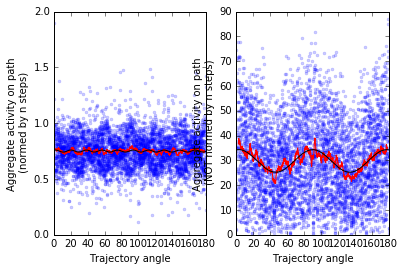

In [30]:
# Ok now try fitting a sinusoidal model to the smoothed traversal data and see what the frequency is
# (but note that this is a bit weird because its not a sinusoid that generated this in first place)

fitToMean = False   # fit to raw traversal data or the smoothed traversal data (should be False, True is just for sanity check)
smoothActivity = [smoothNormPathActivity, smoothPathActivity]
activity = [sortedNormPathActivity, sortedPathActivity]
smoothSortedAngles = smoothSortedAngles.flatten()
sortedAngles = sortedAngles.flatten()


numiter = 500
fig, ax = plt.subplots(1,len(activity))

for i in range(len(activity)):
    if fitToMean:
        data = smoothActivity[i].flatten()
    else:
        data = activity[i].flatten()
    initparams = [0.1, 10, 0, 0]   # amplitude, spacing, phase, yoffset
    fitted_params, fitted_SSE = gf.fitSinusoidalModels(data, numiter, initparams)
    if i==0:
        print("Fitting to normed data (uniform aross distance over square)...")
    else:
        print("Fitting to NOT normed data (uniform aross start and end positions on square) ...")
    #--------------------
    # See what the best fitting parameters were
    opt_iter = np.nanargmin(fitted_SSE)
    opt_params = fitted_params[opt_iter][:]
    str_params = ''.join("{:.3f}  ".format(e) for e in opt_params)
    print("Best fitting parameters: "+ str_params)
    print("Best fitting periodicity: {:.3f} degrees".format(opt_params[1]) )
    #--------------------
    # Simulate the best fitting model on top of the data
    ax[i].plot(sortedAngles, activity[i].flatten(), '.', alpha=0.2)   # data
    ax[i].plot(smoothSortedAngles, smoothActivity[i], 'r')            # filtered/smoothed data
    if fitToMean:
        zfit = gf.sinusoidal(smoothSortedAngles, *opt_params) 
        ax[i].plot(smoothSortedAngles, zfit, color='black')
    else:
        zfit = gf.sinusoidal(sortedAngles, *opt_params)
        ax[i].plot(sortedAngles, zfit, color='black')

ax[0].set_xlabel('Trajectory angle')
ax[0].set_ylabel('Aggregate activity on path\n (normed by n steps)')
ax[1].set_xlabel('Trajectory angle')
ax[1].set_ylabel('Aggregate activity on path\n (NOT normed by n steps)')



# ***HRS Is the only way we would get 6 fold symmetry out of this plot by having particular constraints upon the relative spacing vs noise? 
# One important thing to remember is that the grids ARE NOT sinusoidal. Noise and spacing are independent! 
# This will have consquences for aggregate activity.

# ***HRS BIG IF this is real (60deg for the normalised data fitting, and 90deg for the not normalised data fitting,
# so basically if you sample uniformly in distance across the square you will get 6-fold, but if you sample according to the distribution of the square axes (uniform in start and end position) you will end up with 4-fold)
# Note that we would need to show this robustly, and for different angles of grid orientation relative to the square, and for different parameter values

# note that for normed data it either solves for 15 deg separation of 60 deg separation (but 15 deg is 24-fold which they didnt test).
# ... but interestingly it DOES seem that we get 4-fold symmetry out of this if you have non-normalised traversals. 
# So it really does depend on the sampling of the map being traversed.

# Ok... Now try this whole procedure again but for different grid orientations because this will matter massively

# Perhaps we can tell something about the alignment of the A axis of the grid (whatever fold) to the 2D environment


# perhaps finding 4-fold symmetry in the NOT normed circular sampling tells us only that when we do our approximation to x,y coordinates, this introduces a 4fold axis bias? 
# So distances are longer slightly in the x,y axis-aligned cases? but this approximation to discrete x,y units should be TINY!
# ***HRS the sampling of the space looks to be x,y axis aligned? like in clusters? wtf, this is probably whats imposing some sort of 4-fold symmetry
# I dont understand how that is coming about though. Discretisation to integer indices should be clustering at units of 1 pixel only.

# I think the moral of the story is that the way you sample this 2D space really really matters for the resulting aggregate activity. 
# and in Alexa's paper I dont think there is any normalisation of the traversal of the space to the distance travelled.
# 


In [ ]:
# This is a test of sinusoid fitting to noisy data... (fits well to data and mean, but better to data which it should)
genparams = [1, 60, 0, 0.5]
testActivity = gf.sinusoidal(np.reshape(sortedAngles, len(sortedAngles)), *genparams)
testActivity += np.random.normal(size=(len(testActivity),))
testActivity = np.reshape(testActivity, (len(testActivity),1))
smoothTestActivity = np.convolve(np.reshape(testActivity, len(testActivity)), np.ones((win,))/win, mode='valid')

plt.plot(np.reshape(sortedAngles, len(sortedAngles)), np.reshape(testActivity, len(testActivity)), '.', alpha=0.2)
plt.plot(smoothSortedAngles, smoothTestActivity, 'r')
data = np.reshape(testActivity, len(testActivity))
initparams = [0.1, 10, 0, 0]   # amplitude, spacing, phase, yoffset
fitted_params, fitted_SSE = gf.fitSinusoidalModels(data, 50, initparams)

#--------------------
# See what the best fitting parameters were
opt_iter = np.nanargmin(fitted_SSE)
opt_params = fitted_params[opt_iter][:]
str_params = ''.join("{:.3f}  ".format(e) for e in opt_params)
print("Best fitting parameters: "+ str_params)
print("Best fitting periodicity: {:.3f} degrees".format(opt_params[1]) )
print("Actual generative parameters: " +str(genparams))
#--------------------
# Simulate the best fitting model on top of the data
zfit = gf.sinusoidal(np.reshape(sortedAngles, len(sortedAngles)), *opt_params)
plt.plot(np.reshape(sortedAngles, len(sortedAngles)), testActivity, '.', alpha=0.2)
plt.plot(np.reshape(sortedAngles, len(sortedAngles)), data, 'r')
plt.plot(np.reshape(sortedAngles, len(sortedAngles)), zfit, color='black')